In [1]:
import keras
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import os
import random
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

def load_trace_dataset(purpose='categorical', ttype='test'):
    suffix = "{0}_{1}.pickled".format(purpose, ttype)
    p = data_path.replace(".xes", suffix)
    return pickle.load(open(p, "rb"))

def calculate_standard_percentile_precisions(model, input_batches, output_batches, input_shape, percentile_steps = 10):
    percentile_matches  = [0] * percentile_steps
    percentile_elements = [0] * percentile_steps

    for x,y in zip(input_batches, output_batches):
        y_hat = model.predict(x.reshape(input_shape))[0]
        current_percentile = 1
        percentile_step = len(x) / percentile_steps

        # loop through predicted next steps and compare
        for i in range(0,len(y)):
            if i > (current_percentile * percentile_step):
                current_percentile += 1

            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                # 0-based indexing, this is actually the 1st percentile
                percentile_matches[current_percentile -1] += 1
            percentile_elements[current_percentile -1] += 1

    return [p_m / p_t for p_m,p_t in zip(percentile_matches,percentile_elements)]

def calculate_bipartite_percentile_precisions(model, input_batches, sec_input_batches, output_batches, input_shape, sec_input_shape, percentile_steps = 10):
    percentile_matches  = [0] * percentile_steps
    percentile_elements = [0] * percentile_steps

    for x1,x2,y in zip(input_batches, sec_input_batches, output_batches):
        x1 = x1.reshape(input_shape)
        x2 = x2.reshape(sec_input_shape)
        y_hat = model.predict({'seq_input': x1, 'sec_input': x2})[0]
        
        current_percentile = 1
        percentile_step = len(y) / percentile_steps

        # loop through predicted next steps and compare
        for i in range(0,len(y)):
            if i > (current_percentile * percentile_step):
                current_percentile += 1

            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                # 0-based indexing, this is actually the 1st percentile
                percentile_matches[current_percentile -1] += 1
            percentile_elements[current_percentile -1] += 1

    return [p_m / p_t for p_m,p_t in zip(percentile_matches,percentile_elements)]

def grouped_percentile_calculation(evm, schm, sp2m, pfsm):
    ev_ind_precisions = calculate_standard_percentile_precisions(evm,
                                                                 evermann_input_batches,
                                                                 evermann_target_batches,
                                                                 input_shape=(1,-1,1),
                                                                 percentile_steps = percentiles)
    sch_ind_precisions = calculate_standard_percentile_precisions(schm,
                                                                 schoenig_input_batches,
                                                                 schoenig_target_batches,
                                                                 input_shape=(1,-1,n_train_cols),
                                                                 percentile_steps = percentiles)
    sp2_ind_precisions = calculate_bipartite_percentile_precisions(sp2m,
                                                                  schoenig_input_batches,
                                                                  test_traces_sp2,
                                                                  schoenig_target_batches,
                                                                  input_shape=(1,-1,n_train_cols),
                                                                  sec_input_shape=(1,-1,n_sp2_cols),
                                                                  percentile_steps = percentiles)
    pfs_ind_precisions = calculate_bipartite_percentile_precisions(pfsm,
                                                                  schoenig_input_batches,
                                                                  test_traces_pfs,
                                                                  schoenig_target_batches,
                                                                  input_shape=(1,-1,n_train_cols),
                                                                  sec_input_shape=(1,-1,n_pfs_cols),
                                                                  percentile_steps = percentiles)
    
    return ev_ind_precisions, sch_ind_precisions, sp2_ind_precisions, pfs_ind_precisions

##### CONFIGURATION SETUP ####
data_path = "../logs/bpic2011/normalized/.xes"
target_variable = "concept:name"
percentiles = 20
sns.set(rc={'figure.figsize':(15,10)})
### CONFIGURATION SETUP END ###

test_traces_categorical = load_trace_dataset('categorical', 'test')
test_traces_ordinal = load_trace_dataset('ordinal', 'test')
test_traces_sp2 = load_trace_dataset('sp2', 'test')
test_traces_pfs = load_trace_dataset('pfs', 'test')
test_targets = load_trace_dataset('target', 'test')
feature_dict = load_trace_dataset('mapping', 'dict')

Using TensorFlow backend.


In [2]:
# TODO: reuse the newly packaged functions to avoid implementation differences
evermann_test_traces    = [ t[target_variable].map(feature_dict[target_variable]['to_int']).values for t in test_traces_categorical ]
evermann_input_batches  = np.array([ t.reshape((-1,1)) for t in evermann_test_traces ])
evermann_target_batches = np.array([ t.values.reshape((-1,625)) for t in test_targets])

schoenig_test_traces = [None] * len(test_traces_categorical)

# PREPARE SCHOENIG DATA
for col in test_traces_categorical[0].columns:
    nc = len(feature_dict[col]['to_int'].values())
    for i in range(0, len(test_traces_categorical)):
        tmp = test_traces_categorical[i][col].map(feature_dict[col]['to_int'])
        tmp = keras.utils.to_categorical(tmp, num_classes=nc)
        tmp = pd.DataFrame(tmp).add_prefix(col)

        schoenig_test_traces[i] = pd.concat([schoenig_test_traces[i], tmp], axis=1)

# tie everything together since we only have a single input layer
schoenig_test_traces = [ pd.concat([a,b], axis=1) for a,b in zip(test_traces_ordinal, schoenig_test_traces)]
n_train_cols  = len(schoenig_test_traces[0].columns)
n_target_cols = len(test_targets[0].columns)

schoenig_input_batches  = np.array([ t.values.reshape((-1,n_train_cols))  for t in schoenig_test_traces ])
schoenig_target_batches = np.array([ t.values.reshape((-1,n_target_cols)) for t in test_targets])

# PREPARE SP2 data
n_sp2_cols = len(test_traces_sp2[0].columns)
test_traces_sp2 = [ t.values for t in test_traces_sp2 ]

# PREPARE PFS data
n_pfs_cols = len(test_traces_pfs[0].columns)
test_traces_pfs = [ t.values for t in test_traces_pfs ]

In [78]:
# plotting helper functions
def plot_precisions(evm_prec, sch_prec, sp2_prec, pfs_prec):
    d = {
        'Evermann et al.': evm_prec,
        'Schönig et al.':  sch_prec,
        'SP2': sp2_prec,
        'PFS': pfs_prec
    }
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    d = pd.DataFrame(d, index=range(1,percentiles+1))

    ax = sns.lineplot(data=d, ax=ax)
    
def plot_statistics(evm_stats, sch_stats, sp2_stats, pfs_stats):
    cols = ['loss', 'val_loss','acc', 'val_acc']
    secy_cols = ['acc', 'val_acc']
    plotstyle = ['-','-','-.','-.']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,15))
    axs = axs.reshape((-1))

    for i in range(3):
        axs[i].set(xlabel='Epochs', ylabel='Loss')

    evm_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[0]).set_title('Evermann')
    sch_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[1]).set_title('Schönig')
    sp2_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[2]).set_title('SP2')
    pfs_stats[cols].plot(secondary_y=secy_cols, kind='line', style=plotstyle, ax=axs[3]).set_title('PFS')
    
def plot_timings(t_evm, t_sch, t_sp2, t_pfs):
    d = {
        'Evermann et al.': t_evm,
        'Schönig et al.':  t_sch,
        'SP2': t_sp2,
        'PFS': t_pfs
    }
    d = pd.DataFrame(d, index=range(1,len(t_sch+1)))

    ax = sns.lineplot(data=d)
    ax.set(xlabel='Epochs', ylabel='Time (s)')

# One-trace-per-batch performance evaluation

In [5]:
evm_model = keras.models.load_model("../../docker_share/evermann/individual/best_val_loss_e35.hdf5")
sch_model = keras.models.load_model("../../docker_share/schoenig/individual/best_val_loss_e27.hdf5")
sp2_model = keras.models.load_model("../../docker_share/sp2/individual/best_val_loss_e26.hdf5")
pfs_model = keras.models.load_model("../../docker_share/pfs/individual/best_val_loss_e26.hdf5")

evm_ind_precisions, sch_ind_precisions, sp2_ind_precisions, pfs_ind_precision = grouped_percentile_calculation(evm_model, sch_model, sp2_model, pfs_model)

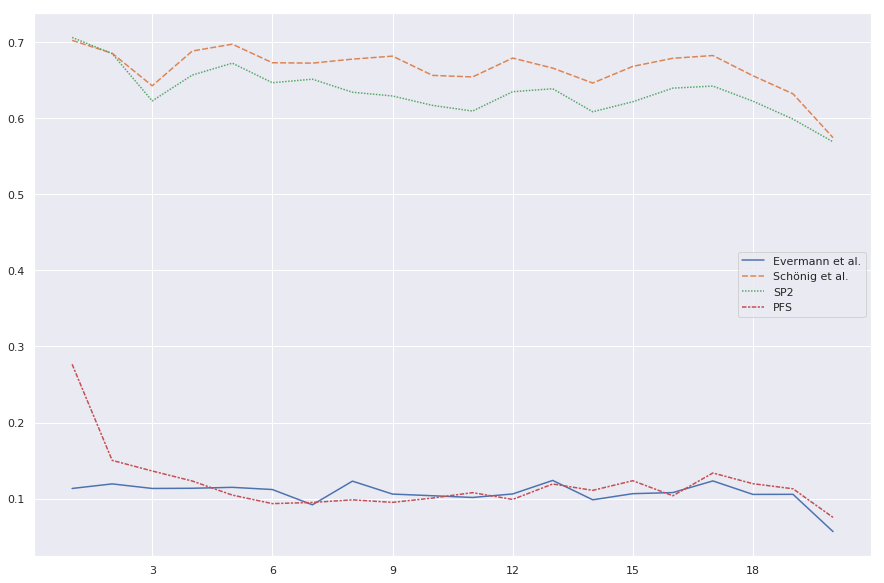

In [79]:
plot_precisions(evm_ind_precisions, sch_ind_precisions, sp2_ind_precisions, pfs_ind_precision)

# One-trace-per-batch training statistics

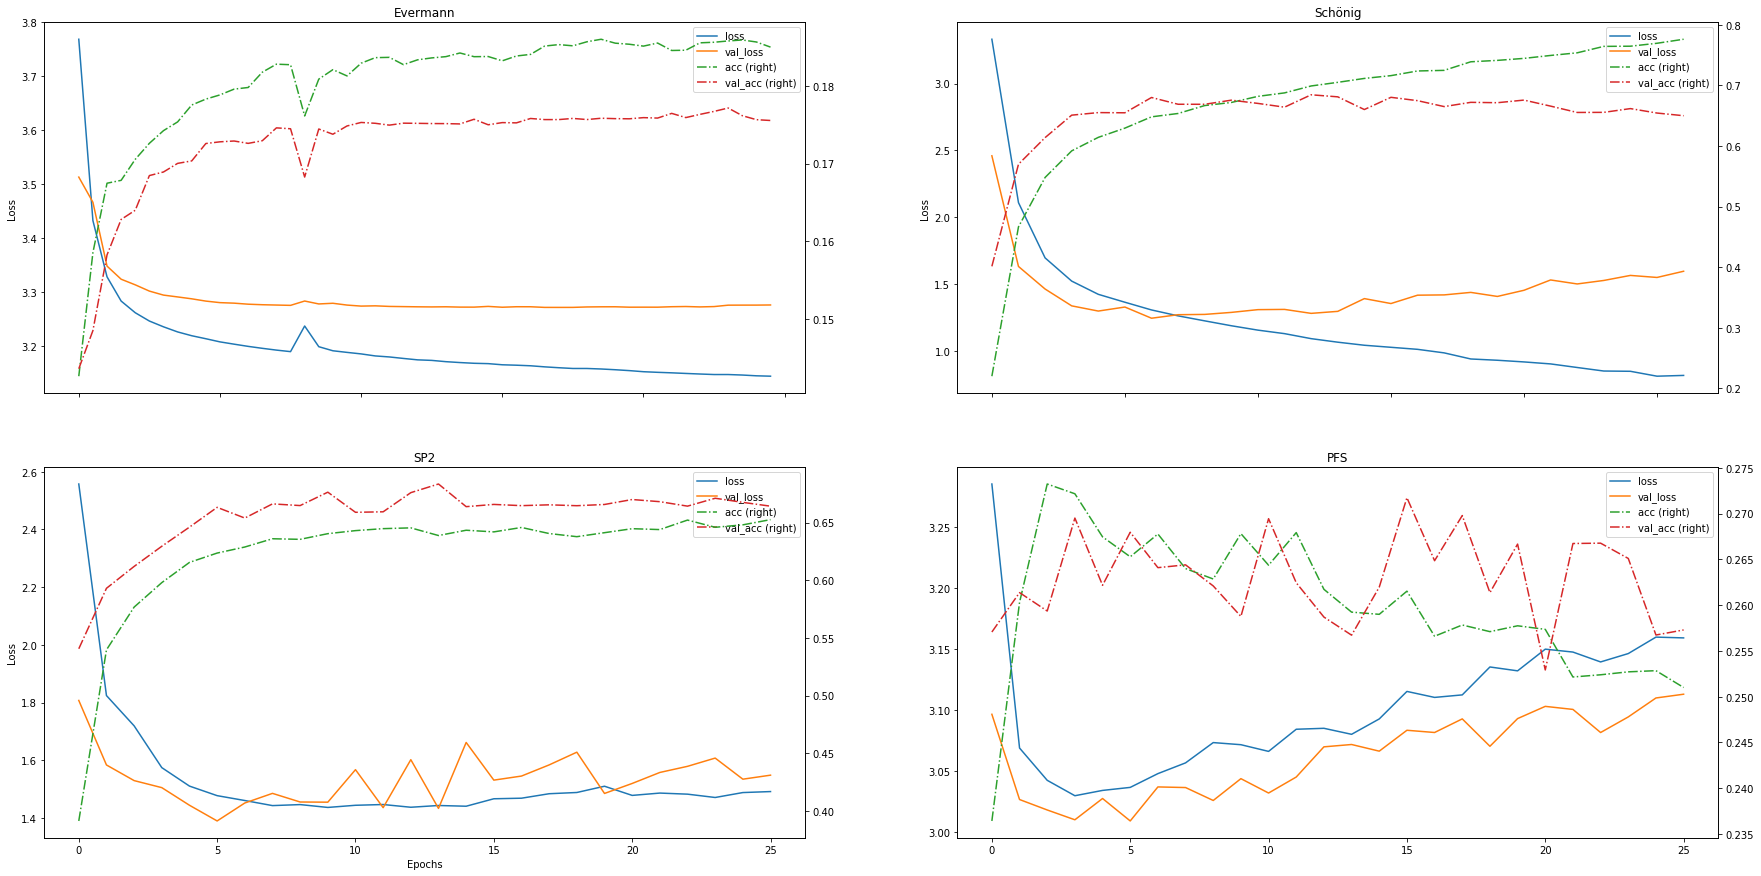

In [47]:
evm_ind_stats  = pd.read_pickle('/home/felix.wolff2/docker_share/evermann/individual/train_statistics.pickled')
sch_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/schoenig/individual/train_statistics.pickled')
sp2_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/sp2/individual/train_statistics.pickled')
pfs_ind_stats = pd.read_pickle('/home/felix.wolff2/docker_share/pfs/individual/train_statistics.pickled')

plot_statistics(evm_ind_stats, sch_ind_stats, sp2_ind_stats, pfs_ind_stats)

# One-trace-per-batch training timings

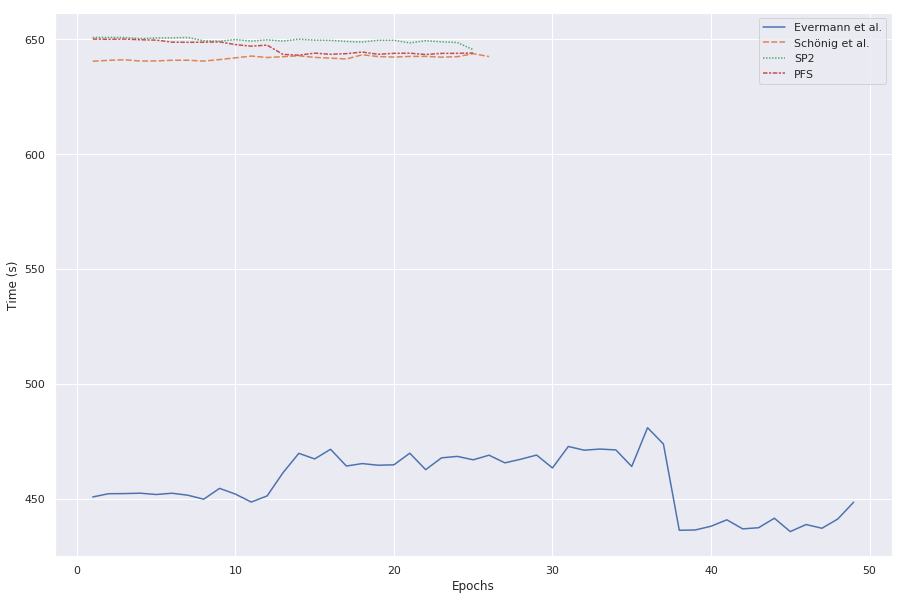

In [59]:
plot_timings(evm_ind_stats['training_time'], sch_ind_stats['training_time'], sp2_ind_stats['training_time'], pfs_ind_stats['training_time'])

# Traces-grouped-by-length-into-batch evaluation

In [29]:
evm_model = keras.models.load_model("../../docker_share/evermann/grouped/best_val_loss_e44.hdf5")
sch_model = keras.models.load_model("../../docker_share/schoenig/grouped/best_val_loss_e5.hdf5")
sp2_model = keras.models.load_model("../../docker_share/sp2/grouped/best_val_loss_e38.hdf5")
pfs_model = keras.models.load_model("../../docker_share/pfs/grouped/best_val_loss_e32.hdf5")

evm_grp_precisions, sch_grp_precisions, sp2_grp_precisions, pfs_grp_precision = grouped_percentile_calculation(evm_model, sch_model, sp2_model, pfs_model)

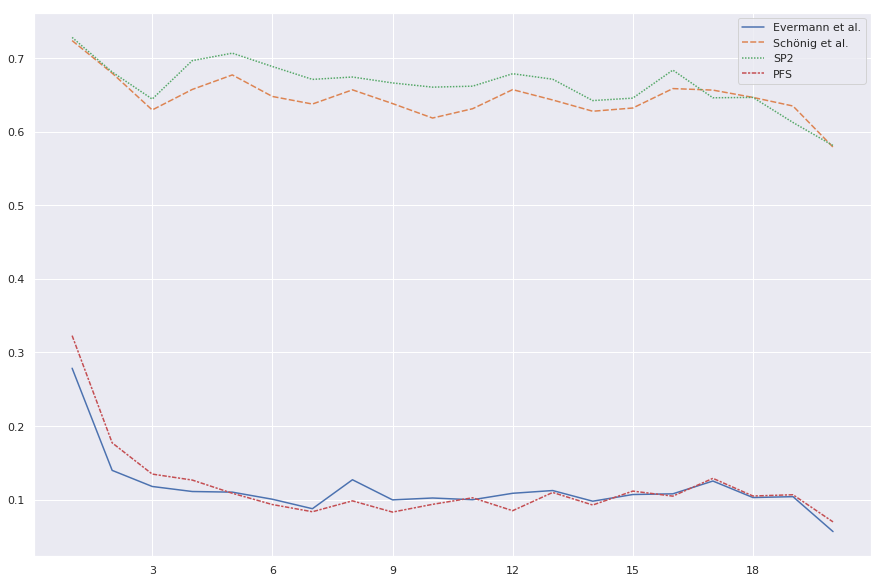

In [80]:
plot_precisions(evm_grp_precisions, sch_grp_precisions, sp2_grp_precisions, pfs_grp_precision)

# Traces-grouped-by-length-into-batch training statistics

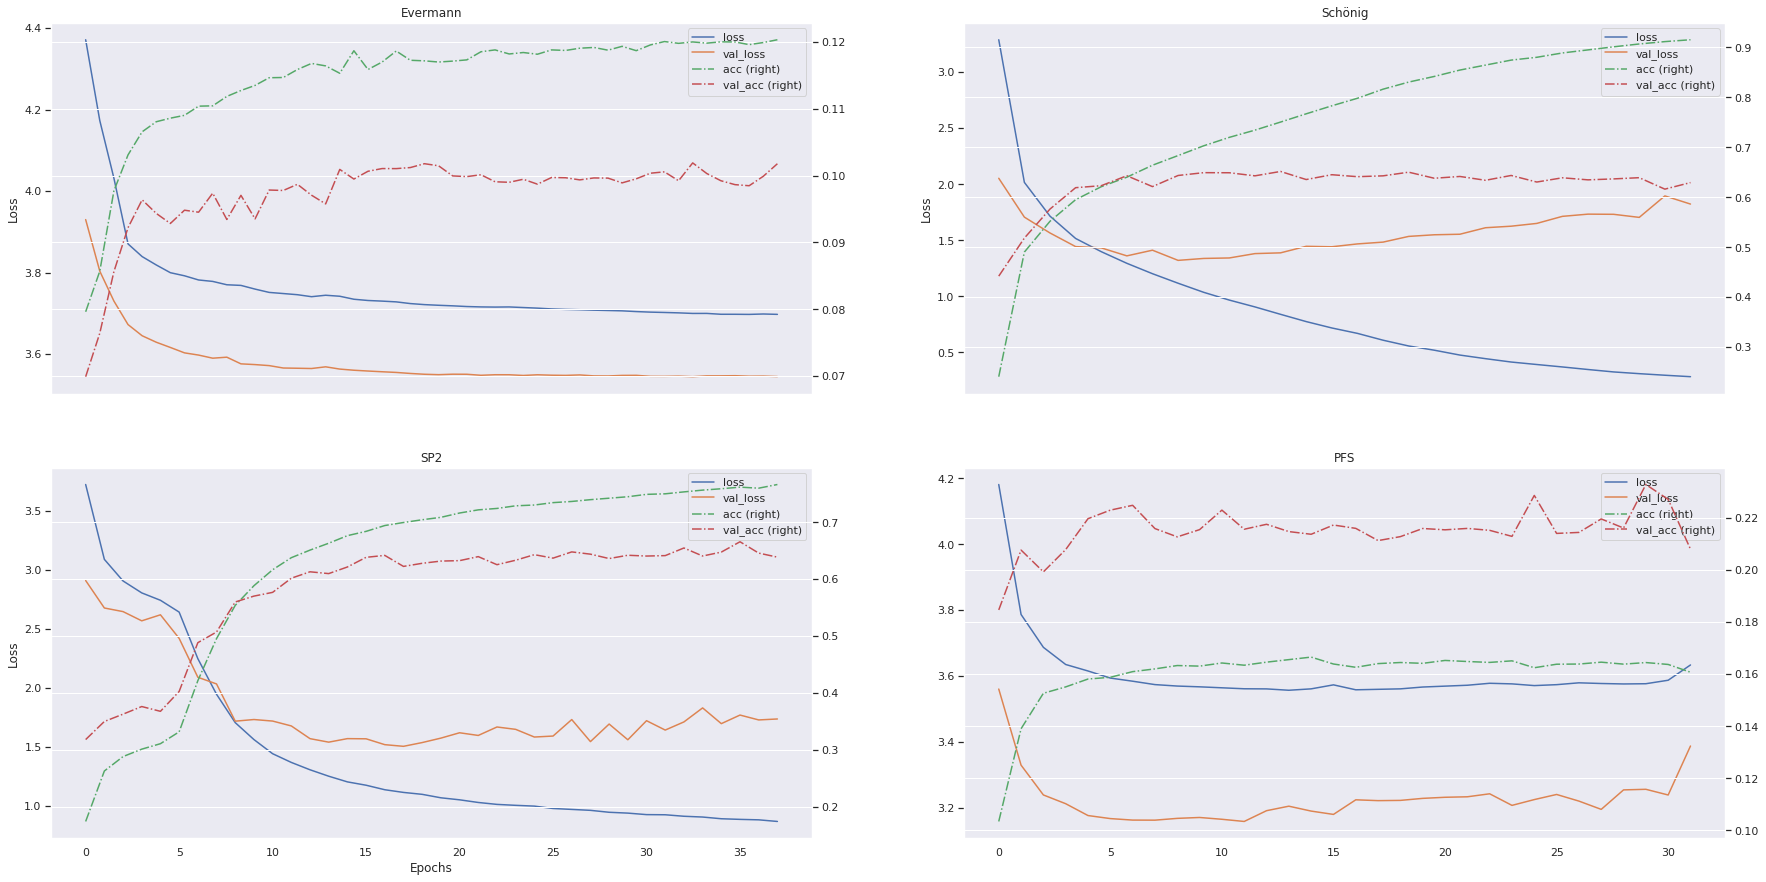

In [61]:
evm_grp_stats  = pd.read_pickle('/home/felix.wolff2/docker_share/evermann/grouped/train_statistics.pickled')
sch_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/schoenig/grouped/train_statistics.pickled')
sp2_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/sp2/grouped/train_statistics.pickled')
pfs_grp_stats = pd.read_pickle('/home/felix.wolff2/docker_share/pfs/grouped/train_statistics.pickled')

plot_statistics(evm_grp_stats, sch_grp_stats, sp2_grp_stats, pfs_grp_stats)

# Traces-grouped-by-length-into-batch training timings

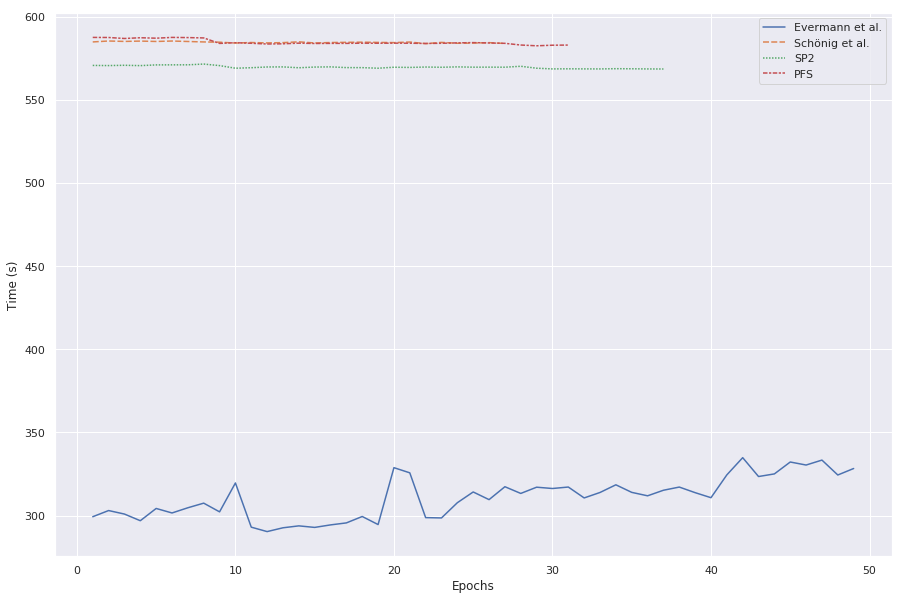

In [63]:
plot_timings(evm_grp_stats['training_time'], sch_grp_stats['training_time'], sp2_grp_stats['training_time'], pfs_grp_stats['training_time'])

# Traces-padded-to-fixed-length evaluation

In [65]:
evm_model = keras.models.load_model("../../docker_share/evermann/padded/best_val_loss_e50.hdf5")
sch_model = keras.models.load_model("../../docker_share/schoenig/padded/best_val_loss_e41.hdf5")
sp2_model = keras.models.load_model("../../docker_share/sp2/padded/best_val_loss_e35.hdf5")
pfs_model = keras.models.load_model("../../docker_share/pfs/padded/best_val_loss_e18.hdf5")

evm_pad_precisions, sch_pad_precisions, sp2_pad_precisions, pfs_pad_precision = grouped_percentile_calculation(evm_model, sch_model, sp2_model, pfs_model)

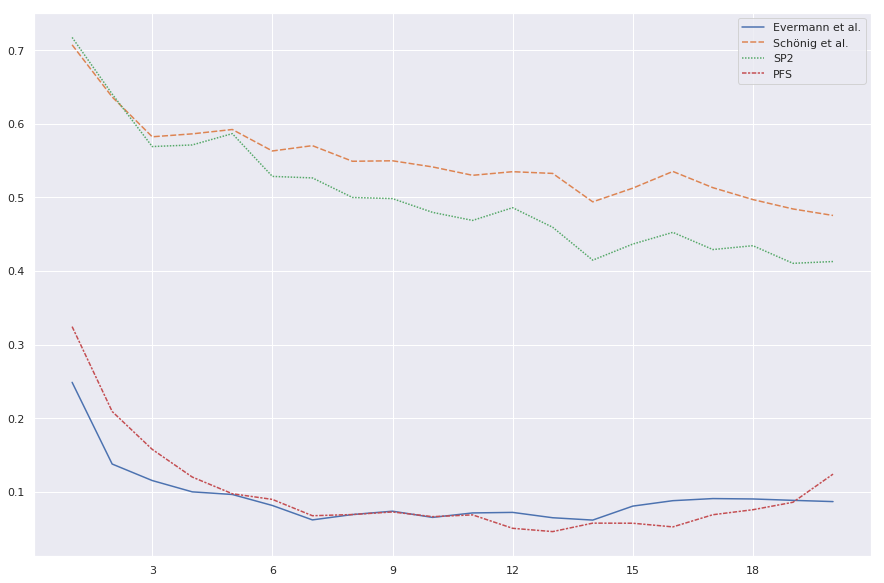

In [81]:
plot_precisions(evm_pad_precisions, sch_pad_precisions, sp2_pad_precisions, pfs_pad_precision)

# Traces-padded-to-fixed-length training statistics

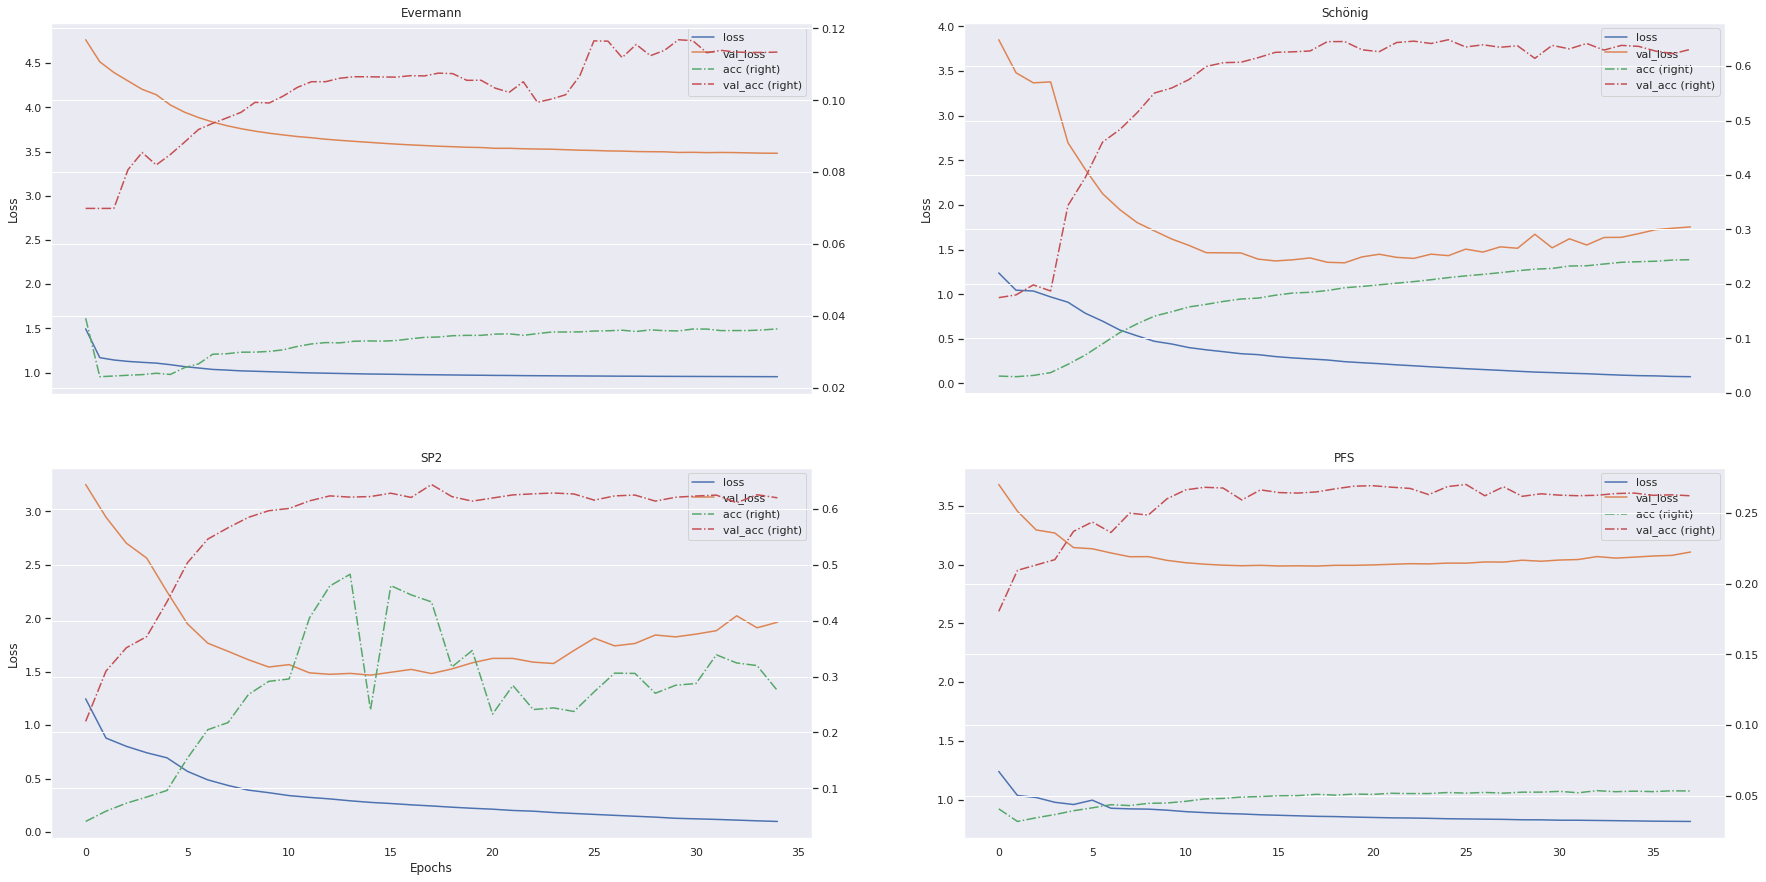

In [82]:
evm_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/evermann/padded/train_statistics.pickled')
sch_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/schoenig/padded/train_statistics.pickled')
sp2_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/sp2/padded/train_statistics.pickled')
pfs_pad_stats = pd.read_pickle('/home/felix.wolff2/docker_share/pfs/padded/train_statistics.pickled')

plot_statistics(evm_pad_stats, sch_pad_stats, sp2_pad_stats, pfs_pad_stats)

# Traces-padded-to-fixed-length training timings

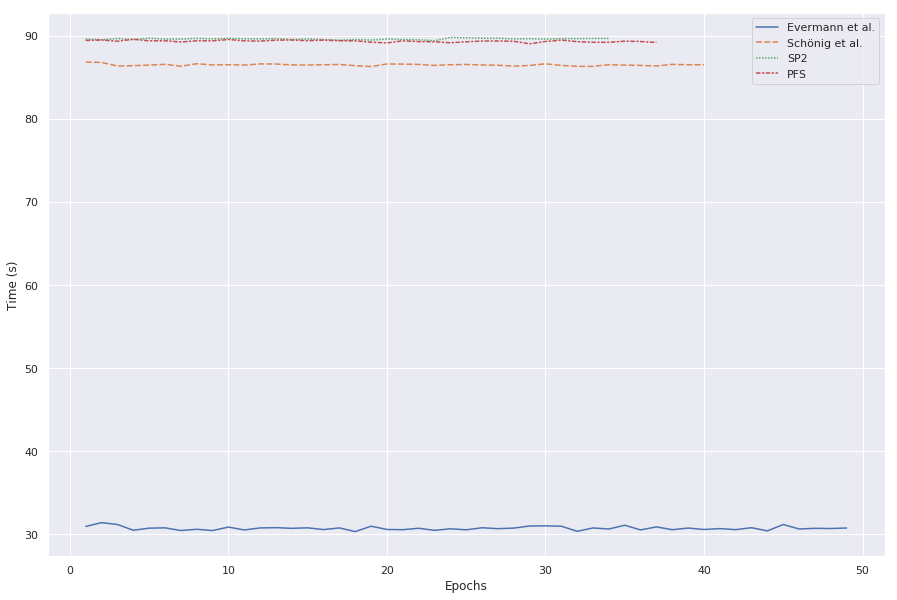

In [84]:
plot_timings(evm_pad_stats['training_time'], sch_pad_stats['training_time'], sp2_pad_stats['training_time'], pfs_pad_stats['training_time'])

# Work in progress

# Schönig feature importance evaluation

In [ ]:
# sklearn is (not yet?) able to permute 3-D input or 2-D input. Thus
def generate_score_function(model, input_shape):
    def score_model(x, y):
        t_acc = 0
        y_hat = model.predict(x.reshape(input_shape))[0]

        for i in range(0,len(y)): # loop through predicted next steps and compare
            # infer one-hot encoding and check if a prediction has been made correctly
            if np.argmax(y_hat[i]) == np.argmax(y[i]):
                t_acc += 1

        return t_acc / len(x)
    return score_model

n_tests = 10#len(schoenig_input_batches)
base_scores = [None] * n_tests
score_decreases = [None] * n_tests
feature_importances = [None] * n_tests

for i in range(0, n_tests):
    base_scores[i], score_decreases[i] = get_score_importances(generate_score_function(schoenig_model,
                                                                            (1,-1,n_train_cols)),
                                                    schoenig_input_batches[i],
                                                    schoenig_target_batches[i])
    feature_importances[i] = np.mean(score_decreases[i], axis=0)
    
sum(feature_importances) / n_tests